# Extension for OST
## Gait Data Preprocessing & Quality Analysis

**Student Name:** Bakhtiyor Sohibnazarov   
**Student ID:** Z22590018   
**Module:** Final Year Project   
**Updated:** 12th December 2025 

This notebook:
1. Loads raw 3D joint data captured by the OST system.
2. Cleans and filters the data (interpolation + One Euro filter).
3. Reduces to key biomechanical joints.
4. Assesses data quality (missing data, bone-length stability, velocity spikes).
5. Detects heel strikes and computes basic gait metrics (cadence, step length, etc.).
6. Produces compact, explainable summaries and a small set of diagnostic plots.

In [21]:
# Install necessary libraries
!pip -q install pandas numpy scipy scikit-learn seaborn ipywidgets reportlab

In [12]:
# ============================================================
# 1. IMPORTS & GLOBAL CONFIGURATION
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from math import sqrt

# Table Formats
pd.set_option("display.precision", 4)
pd.set_option("display.width", 120)

# ------------------------------------------------------------
# File paths 
# ------------------------------------------------------------
INPUT_CSV_RAW          = "data/28.11_raw.csv"
OUTPUT_CSV_FILTERED    = "output/28.11_filtered.csv"
OUTPUT_CSV_REDUCED     = "output/28.11_preprocessed.csv"

# ------------------------------------------------------------
# Capture / timing
# ------------------------------------------------------------
TIMESTAMP_COLUMN       = "timestamp"   # set to None if no timestamp
TIMESTAMP_FORMAT       = "auto"        # currently unused; assumes numeric / seconds

# ------------------------------------------------------------
# Interpolation settings
# ------------------------------------------------------------
MAX_INTERP_GAP         = 3   # max consecutive NaN frames to interpolate inside

# ------------------------------------------------------------
# One Euro filter parameters (for smoothing)
# ------------------------------------------------------------
MIN_CUTOFF             = 0.5    # smoothing for slow movements
BETA                   = 0.02   # speed-based dynamic smoothing
DCUTOFF                = 1.0    # derivative cutoff

# ------------------------------------------------------------
# Heel-strike detection
# ------------------------------------------------------------
LEFT_HEEL_INDEX        = 29
RIGHT_HEEL_INDEX       = 30
MIN_PEAK_DISTANCE_SEC  = 0.40   # minimum time between heel strikes (same leg)
PEAK_PROMINENCE        = 0.001  # minima depth threshold (after inversion)


## 2. Utility functions

We define helpers for:
- One Euro filter (for smooth but responsive coordinates)
- Interpolation of short gaps
- Joint extraction
- Small reporting helpers


In [13]:
# ============================================================
# 2. UTILITY FUNCTIONS
# ============================================================

def lowpass(prev, curr, alpha):
    return alpha * curr + (1 - alpha) * prev

def compute_alpha(cutoff, dt):
    if cutoff <= 0:
        return 1.0
    tau = 1.0 / (2 * np.pi * cutoff)
    return 1.0 / (1.0 + tau / dt)

class OneEuroFilter:
    """
    Simple One Euro filter implementation for 1D signals.
    """
    def __init__(self, min_cutoff=1.0, beta=0.0, d_cutoff=1.0):
        self.min_cutoff = float(min_cutoff)
        self.beta = float(beta)
        self.d_cutoff = float(d_cutoff)
        self.x_prev = None
        self.dx_prev = None
        self.t_prev = None

    def __call__(self, t, x):
        if self.t_prev is None:
            self.t_prev = t
            self.x_prev = x
            self.dx_prev = np.zeros_like(x)
            return x

        dt = t - self.t_prev
        if dt <= 0:
            # No time progression, nothing to filter
            return x

        # Derivative (raw)
        dx = (x - self.x_prev) / dt

        # Filter derivative
        alpha_d = compute_alpha(self.d_cutoff, dt)
        dx_hat = lowpass(self.dx_prev, dx, alpha_d)

        # Dynamic cutoff
        cutoff = self.min_cutoff + self.beta * np.abs(dx_hat)
        alpha = compute_alpha(cutoff, dt)

        # Filtered signal
        x_hat = lowpass(self.x_prev, x, alpha)

        # Store state
        self.x_prev = x_hat
        self.dx_prev = dx_hat
        self.t_prev = t

        return x_hat

def interpolate_short_gaps(arr, max_gap):
    """
    Linearly interpolates NaN gaps up to 'max_gap' in length (in samples).
    For longer gaps, leaves NaNs as-is.
    Works on 1D numpy arrays.
    """
    arr = arr.copy()
    n = len(arr)

    # Indices where values are missing
    nan_idx = np.where(np.isnan(arr))[0]
    if len(nan_idx) == 0:
        return arr

    # Find consecutive NaN segments
    start = nan_idx[0]
    for i in range(1, len(nan_idx)):
        if nan_idx[i] != nan_idx[i-1] + 1:
            end = nan_idx[i-1]
            gap_len = end - start + 1
            if gap_len <= max_gap:
                # interpolate between arr[start-1] and arr[end+1] if they exist
                left = start - 1
                right = end + 1
                if left >= 0 and right < n and not np.isnan(arr[left]) and not np.isnan(arr[right]):
                    arr[start:end+1] = np.interp(
                        np.arange(start, end+1),
                        [left, right],
                        [arr[left], arr[right]]
                    )
            start = nan_idx[i]

    # handle last segment
    end = nan_idx[-1]
    gap_len = end - start + 1
    if gap_len <= max_gap:
        left = start - 1
        right = end + 1
        if left >= 0 and right < n and not np.isnan(arr[left]) and not np.isnan(arr[right]):
            arr[start:end+1] = np.interp(
                np.arange(start, end+1),
                [left, right],
                [arr[left], arr[right]]
            )

    return arr

def get_joint_array(df, j_idx, mask=None):
    """
    Returns (N x 3) array for given joint index.
    Columns: joint_{idx}_x, joint_{idx}_y, joint_{idx}_z
    """
    cols = [f"joint_{j_idx}_x", f"joint_{j_idx}_y", f"joint_{j_idx}_z"]
    if mask is None:
        return df[cols].to_numpy()
    return df.loc[mask, cols].to_numpy()

def print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))


## 3. Load raw data and derive time base

We:
- Load the raw CSV
- Derive `time` using timestamp if present, otherwise from frame index
- Estimate effective FPS


In [14]:
# ============================================================
# 3. LOAD RAW DATA & TIME BASE
# ============================================================

print_section("Loading raw data")

df_raw = pd.read_csv(INPUT_CSV_RAW)
print(f"Loaded: {INPUT_CSV_RAW}")
print(f"Shape: {df_raw.shape[0]} frames x {df_raw.shape[1]} columns")

# Detect joint columns
joint_cols = sorted([c for c in df_raw.columns if c.startswith("joint_")], 
                    key=lambda x: (int(x.split("_")[1]), x.split("_")[2]))

# Time handling
if TIMESTAMP_COLUMN is not None and TIMESTAMP_COLUMN in df_raw.columns:
    print("Timestamp column detected → parsing ISO datetime")

    # Parse ISO string to datetime
    t_raw = pd.to_datetime(df_raw[TIMESTAMP_COLUMN], errors='coerce')

    # Convert to seconds (relative to first frame)
    t_sec = (t_raw - t_raw.iloc[0]).dt.total_seconds().to_numpy()

    time = t_sec
else:
    # fallback: synthetic time assuming ~constant FPS
    fps_guess = 30.0
    time = np.arange(len(df_raw)) / fps_guess
    print("No timestamp column detected → using synthetic time @ 30 FPS")

# Summaries
dt = np.diff(time)
median_dt = np.nanmedian(dt)
fps_effective = 1.0 / median_dt

print(f"Median Δt:     {median_dt:.6f} s")
print(f"Effective FPS: {fps_effective:.3f} Hz")

df_raw["time"] = time




Loading raw data
Loaded: data/28.11_raw.csv
Shape: 25410 frames x 100 columns
Timestamp column detected → parsing ISO datetime
Median Δt:     0.066509 s
Effective FPS: 15.036 Hz


## 4. Data quality diagnostics (missing data & basic stability)

Here we compute:
- Missing data rate per joint
- Overall completeness
- Basic bone-length stability (shoulder–shoulder, hip–hip)
- A textual **data quality summary**


In [15]:
# ============================================================
# 4. DATA QUALITY DIAGNOSTICS
# ============================================================

print_section("Data quality diagnostics")

# --- 4.1 Missing data per joint ---
joint_ids = sorted({int(c.split("_")[1]) for c in joint_cols})
missing_stats = []

for j in joint_ids:
    cols = [f"joint_{j}_x", f"joint_{j}_y", f"joint_{j}_z"]
    sub = df_raw[cols]
    missing = sub.isna().any(axis=1).mean() * 100.0
    missing_stats.append({"joint": j, "missing_%": missing})

missing_df = pd.DataFrame(missing_stats).sort_values("missing_%")

overall_missing = df_raw[joint_cols].isna().any(axis=1).mean() * 100.0

print(f"Overall frames with any missing joint: {overall_missing:.2f}%")

display(missing_df.head(10).style.set_caption("Lowest missing % joints"))
display(missing_df.tail(10).style.set_caption("Highest missing % joints"))

# --- 4.2 Bone-length stability (simple example: shoulders & hips) ---
def bone_length(df, j1, j2):
    p1 = get_joint_array(df, j1)
    p2 = get_joint_array(df, j2)
    d = np.linalg.norm(p1 - p2, axis=1)
    return d

shoulder_len = bone_length(df_raw, 11, 12)  # adjust if your indices differ
hip_len      = bone_length(df_raw, 23, 24)

def summarize_bone(name, arr):
    arr = arr[~np.isnan(arr)]
    mean = np.mean(arr)
    std  = np.std(arr)
    print(f"{name}: {mean:.3f} ± {std:.3f} (units of coordinate system)")

print("\nBone length stability:")
summarize_bone("Shoulder width (11–12)", shoulder_len)
summarize_bone("Hip width (23–24)", hip_len)

# --- 4.3 Simple velocity sanity check (ankle as example) ---
# Example: use left ankle indices if known; for now, use LEFT_HEEL as proxy
heel = get_joint_array(df_raw, LEFT_HEEL_INDEX)
vel = np.vstack([np.zeros((1, 3)), np.diff(heel, axis=0)]) / median_dt
speed = np.linalg.norm(vel, axis=1)

speed_threshold = np.nanpercentile(speed, 99.5)  # identify extreme spikes
num_spikes = np.sum(speed > speed_threshold)

print(f"\nVelocity spikes (approx; using left heel): {num_spikes} frames above 99.5th percentile")

# --- 4.4 Quality summary table ---
quality_summary = pd.DataFrame([
    {"Metric": "Frames", "Value": len(df_raw)},
    {"Metric": "Overall missing frames (%)", "Value": f"{overall_missing:.2f}"},
    {"Metric": "Shoulder width mean", "Value": f"{np.nanmean(shoulder_len):.3f}"},
    {"Metric": "Shoulder width std",  "Value": f"{np.nanstd(shoulder_len):.3f}"},
    {"Metric": "Hip width mean",      "Value": f"{np.nanmean(hip_len):.3f}"},
    {"Metric": "Hip width std",       "Value": f"{np.nanstd(hip_len):.3f}"},
    {"Metric": "Velocity spikes (99.5th%)", "Value": int(num_spikes)},
])

display(quality_summary.style.set_caption("Data Quality Summary"))



Data quality diagnostics
Overall frames with any missing joint: 0.55%


,joint,missing_%
12,12,0.000000
8,8,0.003935
13,13,0.003935
7,7,0.007871
11,11,0.007871
6,6,0.007871
5,5,0.007871
4,4,0.007871
23,23,0.007871
15,15,0.011806


,joint,missing_%
26,26,0.043290
16,16,0.047226
27,27,0.051161
28,28,0.055096
25,25,0.055096
18,18,0.078709
31,31,0.086580
32,32,0.102322
29,29,0.106257
30,30,0.161354



Bone length stability:
Shoulder width (11–12): 0.102 ± 0.061 (units of coordinate system)
Hip width (23–24): 0.017 ± 0.011 (units of coordinate system)

Velocity spikes (approx; using left heel): 127 frames above 99.5th percentile


,Metric,Value
0,Frames,25410
1,Overall missing frames (%),0.55
2,Shoulder width mean,0.102
3,Shoulder width std,0.061
4,Hip width mean,0.017
5,Hip width std,0.011
6,Velocity spikes (99.5th%),127


## 5. Preprocessing: interpolate short gaps & apply One Euro filter

We clean the data **in place**:
- Interpolate short NaN gaps (up to `MAX_INTERP_GAP` frames) for each joint coordinate.
- Apply One Euro filter to each coordinate time-series.
- Construct a `valid` mask (frames without remaining NaNs).
- Save a filtered CSV.


In [16]:
# ============================================================
# 5. PREPROCESSING (INTERPOLATION + ONE EURO FILTER)
# ============================================================

print_section("Preprocessing: interpolation + One Euro filter")

df = df_raw.copy()

# Split time for convenience
t = df["time"].to_numpy()

# Prepare filtered dataframe
filtered = pd.DataFrame(index=df.index)
filtered["time"] = t
if TIMESTAMP_COLUMN in df.columns:
    filtered[TIMESTAMP_COLUMN] = df[TIMESTAMP_COLUMN]

# Interpolate and filter each joint coordinate
for j in joint_ids:
    for axis in ["x", "y", "z"]:
        col = f"joint_{j}_{axis}"
        if col not in df.columns:
            continue
        arr = df[col].astype(float).to_numpy()

        # Interpolate short NaN gaps
        arr_interp = interpolate_short_gaps(arr, MAX_INTERP_GAP)

        # One Euro filter (only where not NaN)
        f = OneEuroFilter(min_cutoff=MIN_CUTOFF, beta=BETA, d_cutoff=DCUTOFF)
        arr_filt = np.full_like(arr_interp, np.nan, dtype=float)
        for idx, (ti, xi) in enumerate(zip(t, arr_interp)):
            if np.isnan(xi):
                continue
            arr_filt[idx] = f(ti, xi)

        filtered[col] = arr_filt

# Validity mask: frames with no NaNs in any joint coordinate
joint_cols_filt = [c for c in filtered.columns if c.startswith("joint_")]
valid_mask = ~filtered[joint_cols_filt].isna().any(axis=1)
filtered["valid"] = valid_mask

print(f"Frames valid after preprocessing: {valid_mask.mean()*100:.2f}%")

# Save filtered CSV
filtered.to_csv(OUTPUT_CSV_FILTERED, index=False)
print(f"Saved filtered data → {OUTPUT_CSV_FILTERED}")



Preprocessing: interpolation + One Euro filter


/tmp/ipykernel_460264/3971030078.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered[col] = arr_filt
/tmp/ipykernel_460264/3971030078.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered["valid"] = valid_mask


Frames valid after preprocessing: 99.95%
Saved filtered data → output/28.11_filtered.csv


## 6. Reduce to key joints and export preprocessed dataset

To keep files compact and analysis-focused, we save only:
- Time, optional timestamp
- Selected biomechanically relevant joints
- Validity mask


In [17]:
# ============================================================
# 6. JOINT REDUCTION & EXPORT
# ============================================================

print_section("Reducing to essential joints")

# Example subset (adapt as needed)
KEEP = [
    # Head
    0,

    # Shoulders
    11, 12,

    # Elbows
    13, 14,

    # Wrists
    15, 16,

    # Hips
    23, 24,

    # Knees
    25, 26,

    # Ankles
    27, 28,

    # Heels
    29, 30,
]

keep_cols = []
for j in KEEP:
    keep_cols += [f"joint_{j}_x", f"joint_{j}_y", f"joint_{j}_z"]

base_cols = ["time"]
if TIMESTAMP_COLUMN in filtered.columns:
    base_cols.append(TIMESTAMP_COLUMN)

final_reduced = filtered[base_cols + keep_cols + ["valid"]].copy()
final_reduced.to_csv(OUTPUT_CSV_REDUCED, index=False)

print(f"Saved reduced dataset → {OUTPUT_CSV_REDUCED}")
print(f"Shape: {final_reduced.shape}")



Reducing to essential joints
Saved reduced dataset → output/28.11_preprocessed.csv
Shape: (25410, 48)


## 7. Heel-strike detection and gait metrics

We now:
1. Use filtered, reduced data.
2. Take left and right heel vertical positions.
3. Detect heel strikes as local minima (peaks in `-heel_y`).
4. Compute:
   - Number of heel strikes per leg
   - Cadence (steps per minute)
   - Step times
   - Forward step length (using Z-coordinate difference at heel strikes)
5. Summarise metrics in a compact table.


###### ============================================================
# 7. HEEL-STRIKE DETECTION & GAIT METRICS
# ============================================================

print_section("Heel-strike detection & gait metrics")

df = final_reduced.copy()
time = df["time"].to_numpy()
dt = np.median(np.diff(time))
fps_est = 1.0 / dt

mask_valid = df["valid"].to_numpy()

def joint_xyz(j_idx):
    return get_joint_array(df, j_idx, mask=mask_valid)

L_heel = joint_xyz(LEFT_HEEL_INDEX)
R_heel = joint_xyz(RIGHT_HEEL_INDEX)

L_heel_y = L_heel[:, 1]
R_heel_y = R_heel[:, 1]

# --- 7.1 Detect heel strikes as minima in heel Y (peaks in -Y) ---
min_dist_frames = max(1, int(MIN_PEAK_DISTANCE_SEC * fps_est))

inv_L = -L_heel_y
inv_R = -R_heel_y

L_peaks, _ = find_peaks(inv_L, distance=min_dist_frames, prominence=PEAK_PROMINENCE)
R_peaks, _ = find_peaks(inv_R, distance=min_dist_frames, prominence=PEAK_PROMINENCE)

L_strike_t = time[mask_valid][L_peaks]
R_strike_t = time[mask_valid][R_peaks]

print(f"Left heel strikes detected:  {len(L_peaks)}")
print(f"Right heel strikes detected: {len(R_peaks)}")

# --- 7.2 Cadence & step times ---
def step_times(strike_t):
    if len(strike_t) < 2:
        return np.array([])
    return np.diff(strike_t)

L_step_times = step_times(L_strike_t)
R_step_times = step_times(R_strike_t)

def cadence_from_step_times(step_t):
    if len(step_t) == 0:
        return np.nan
    mean_step = np.mean(step_t)
    # 1 step per step time → convert to steps per minute
    return 60.0 / mean_step

L_cadence = cadence_from_step_times(L_step_times)
R_cadence = cadence_from_step_times(R_step_times)

# --- 7.3 Step length (using forward Z distance between consecutive strikes) ---

L_heel_z = L_heel[:, 2]
R_heel_z = R_heel[:, 2]

# Helper: sample Z at strike indices in valid-mask space
valid_indices = np.where(mask_valid)[0]
L_valid_idx = valid_indices[L_peaks]
R_valid_idx = valid_indices[R_peaks]

L_strike_z = L_heel_z[L_peaks]
R_strike_z = R_heel_z[R_peaks]

# Simplest definition: forward progression between consecutive strikes of same leg
def step_lengths(strike_idx, z_values):
    if len(strike_idx) < 2:
        return np.array([])
    # difference in z between consecutive strikes
    return np.diff(z_values)

L_step_len = step_lengths(L_valid_idx, L_strike_z)
R_step_len = step_lengths(R_valid_idx, R_strike_z)

# --- 7.4 Summarise metrics ---
def summarize_array(name, arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return {f"{name}_mean": np.nan, f"{name}_std": np.nan}
    return {
        f"{name}_mean": float(np.mean(arr)),
        f"{name}_std":  float(np.std(arr))
    }

metrics = {
    "fps_est": fps_est,
    "n_L_strikes": len(L_peaks),
    "n_R_strikes": len(R_peaks),
    "cadence_L_steps_min": L_cadence,
    "cadence_R_steps_min": R_cadence,
}
metrics.update(summarize_array("L_step_time_s", L_step_times))
metrics.update(summarize_array("R_step_time_s", R_step_times))
metrics.update(summarize_array("L_step_len_z", L_step_len))
metrics.update(summarize_array("R_step_len_z", R_step_len))

metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
display(metrics_df.style.set_caption("Gait Metrics Summary"))


## 8. Compact visual diagnostics

We keep plots minimal and meaningful:

1. Left & right heel trajectories with detected strikes.
2. Step length over time (for both legs).



Plotting diagnostics


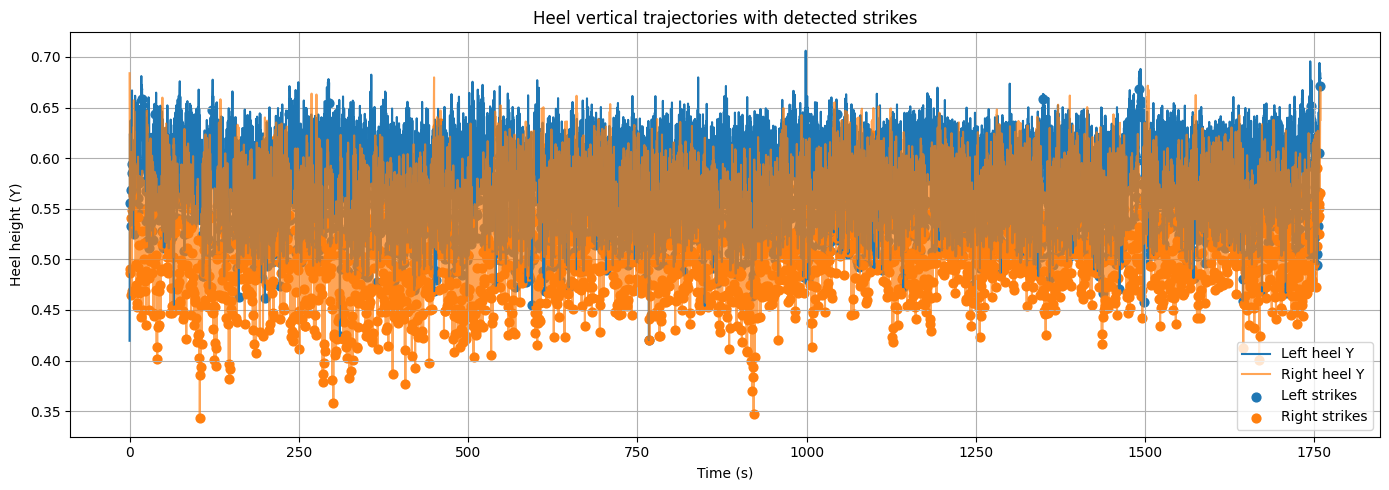

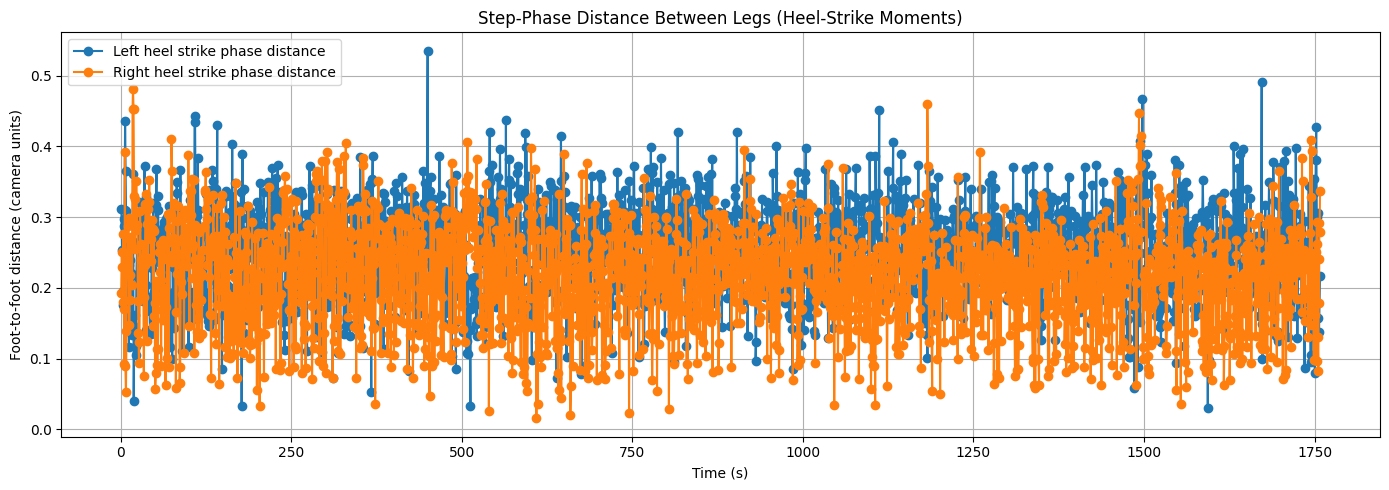


Step-Phase Distance Summary
LEFT heel-strike step-phase distance:
  Steps: 2257
  Mean distance: 0.2520
  Std deviation: 0.0626
  Min distance: 0.0294
  Max distance: 0.5352

RIGHT heel-strike step-phase distance:
  Steps: 2341
  Mean distance: 0.2179
  Std deviation: 0.0700
  Min distance: 0.0155
  Max distance: 0.4807

Symmetry Index:
  0.1449  (0 = perfect symmetry)
  Positive = Left steps have larger separation; Negative = Right steps larger

First 10 L-step distances: [0.312  0.2532 0.1758 0.1954 0.2873 0.2969 0.3094 0.4351 0.3653 0.3083]
First 10 R-step distances: [0.1929 0.2511 0.2298 0.1793 0.2763 0.1706 0.092  0.3922 0.0888 0.0525]


In [18]:
# ============================================================
# 8. PLOTS: HEEL TRAJECTORIES & STEP LENGTHS
# ============================================================

print_section("Plotting diagnostics")

# 8.1 Heel Y trajectories
plt.figure(figsize=(14, 5))
plt.plot(time[mask_valid], L_heel_y, label="Left heel Y")
plt.plot(time[mask_valid], R_heel_y, label="Right heel Y", alpha=0.7)
plt.scatter(L_strike_t, L_heel_y[L_peaks], s=40, label="Left strikes")
plt.scatter(R_strike_t, R_heel_y[R_peaks], s=40, label="Right strikes")
plt.xlabel("Time (s)")
plt.ylabel("Heel height (Y)")
plt.title("Heel vertical trajectories with detected strikes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# Compute 3D distance between feet for each valid frame
# ============================================================

# Heel coordinates already filtered by mask_valid
Lx, Ly, Lz = L_heel[:, 0], L_heel[:, 1], L_heel[:, 2]
Rx, Ry, Rz = R_heel[:, 0], R_heel[:, 1], R_heel[:, 2]

# Euclidean distance in camera 3D space
leg_dist = np.sqrt((Lx - Rx)**2 + (Ly - Ry)**2 + (Lz - Rz)**2)


# 8.2 Distance between legs in camera coordinate system (3D)
# STEP-PHASE DISTANCE (distance between feet at heel strikes)
time_valid = time[mask_valid]
# Distances at heel-strike moments
L_step_phase = leg_dist[L_peaks]
R_step_phase = leg_dist[R_peaks]

L_step_t = time_valid[L_peaks]
R_step_t = time_valid[R_peaks]

plt.figure(figsize=(14,5))

plt.plot(L_step_t, L_step_phase, "o-", label="Left heel strike phase distance")
plt.plot(R_step_t, R_step_phase, "o-", label="Right heel strike phase distance")

plt.xlabel("Time (s)")
plt.ylabel("Foot-to-foot distance (camera units)")
plt.title("Step-Phase Distance Between Legs (Heel-Strike Moments)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Step-Phase Distance Summary (Text Output)
# ============================================================

print_section("Step-Phase Distance Summary")

def summarize_step_phase(name, arr):
    return {
        "count": len(arr),
        "mean": np.mean(arr) if len(arr) > 0 else np.nan,
        "std": np.std(arr) if len(arr) > 0 else np.nan,
        "min": np.min(arr) if len(arr) > 0 else np.nan,
        "max": np.max(arr) if len(arr) > 0 else np.nan,
    }

L_stats = summarize_step_phase("Left", L_step_phase)
R_stats = summarize_step_phase("Right", R_step_phase)

# Symmetry index (0 = perfect symmetry)
sym_index = (L_stats["mean"] - R_stats["mean"]) / ((L_stats["mean"] + R_stats["mean"]) / 2)

print("LEFT heel-strike step-phase distance:")
print(f"  Steps: {L_stats['count']}")
print(f"  Mean distance: {L_stats['mean']:.4f}")
print(f"  Std deviation: {L_stats['std']:.4f}")
print(f"  Min distance: {L_stats['min']:.4f}")
print(f"  Max distance: {L_stats['max']:.4f}")

print("\nRIGHT heel-strike step-phase distance:")
print(f"  Steps: {R_stats['count']}")
print(f"  Mean distance: {R_stats['mean']:.4f}")
print(f"  Std deviation: {R_stats['std']:.4f}")
print(f"  Min distance: {R_stats['min']:.4f}")
print(f"  Max distance: {R_stats['max']:.4f}")

print("\nSymmetry Index:")
print(f"  {sym_index:.4f}  (0 = perfect symmetry)")
print("  Positive = Left steps have larger separation; Negative = Right steps larger")

# Optional: print first few values for quick eyeballing
print("\nFirst 10 L-step distances:", np.round(L_step_phase[:10], 4))
print("First 10 R-step distances:", np.round(R_step_phase[:10], 4))

## Joint Angle Calculations


Joint angle calculations (hip & knee)


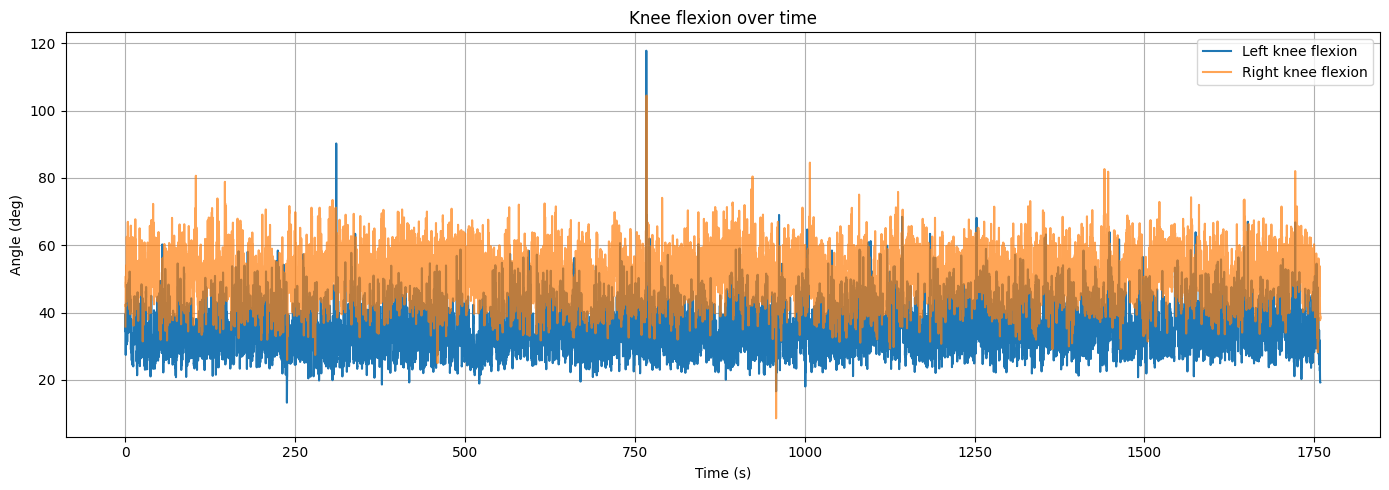

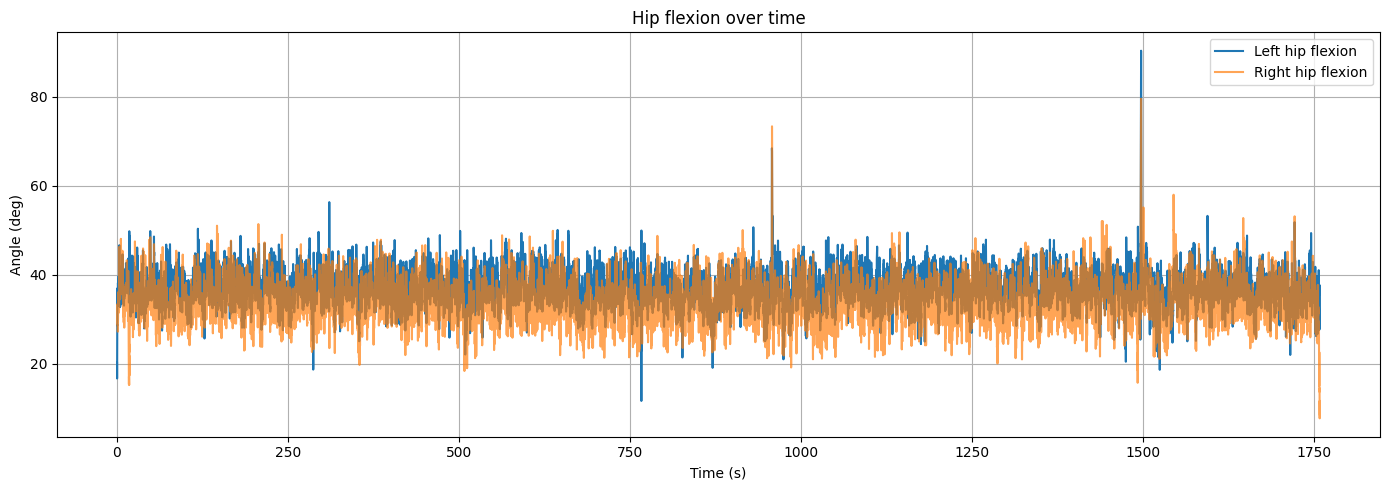


Joint angle summary
Left knee flexion:
  Mean: 35.2°
  Min:  13.3°
  Max:  117.8°
  ROM:  104.5°

Right knee flexion:
  Mean: 50.4°
  Min:  8.6°
  Max:  104.5°
  ROM:  95.8°

Left hip flexion:
  Mean: 37.2°
  Min:  11.6°
  Max:  90.4°
  ROM:  78.8°

Right hip flexion:
  Mean: 33.2°
  Min:  7.7°
  Max:  79.6°
  ROM:  71.9°



In [19]:
# ============================================================
# 10. JOINT ANGLES: HIP & KNEE
# ============================================================

print_section("Joint angle calculations (hip & knee)")

df = final_reduced.copy()
time = df["time"].to_numpy()
mask_valid = df["valid"].to_numpy()
t_valid = time[mask_valid]

def joint_series(j_idx):
    """N_valid x 3 array for joint j_idx on valid frames."""
    return get_joint_array(df, j_idx, mask=mask_valid)

# ---- Get joint coordinates ----
L_hip    = joint_series(23)
R_hip    = joint_series(24)
L_knee   = joint_series(25)
R_knee   = joint_series(26)
L_ankle  = joint_series(27)
R_ankle  = joint_series(28)
L_shldr  = joint_series(11)
R_shldr  = joint_series(12)

def angle_series(proximal, joint, distal):
    """
    Returns angle at 'joint' in degrees for each frame.
    proximal - joint - distal  (three N x 3 arrays)
    Geometric angle between the two bone segments.
    """
    v1 = proximal - joint
    v2 = distal   - joint

    # norms
    n1 = np.linalg.norm(v1, axis=1)
    n2 = np.linalg.norm(v2, axis=1)

    # avoid divide-by-zero
    eps = 1e-8
    n1 = np.where(n1 < eps, eps, n1)
    n2 = np.where(n2 < eps, eps, n2)

    dot = np.einsum("ij,ij->i", v1, v2)
    cosang = dot / (n1 * n2)
    cosang = np.clip(cosang, -1.0, 1.0)

    return np.degrees(np.arccos(cosang))  # 0..180°

# ---- Knee flexion angles ----
L_knee_angle_geom = angle_series(L_hip,  L_knee, L_ankle)
R_knee_angle_geom = angle_series(R_hip,  R_knee, R_ankle)

# Optional convention: 0° = full extension, >0 = flexion
# If you want that, do:
L_knee_flex = 180.0 - L_knee_angle_geom
R_knee_flex = 180.0 - R_knee_angle_geom

# ---- Hip flexion angles (shoulder–hip–knee) ----
# Correct hip flexion using thigh vector vs vertical axis
vertical = np.array([0, 1, 0])  # Y is height

def angle_with_vertical(v):
    v_norm = v / (np.linalg.norm(v, axis=1, keepdims=True) + 1e-9)
    dot = np.einsum("ij,j->i", v_norm, vertical)
    dot = np.clip(dot, -1, 1)
    return np.degrees(np.arccos(dot))

# Thigh vectors
L_thigh = L_knee - L_hip
R_thigh = R_knee - R_hip

L_hip_flex = angle_with_vertical(L_thigh)
R_hip_flex = angle_with_vertical(R_thigh)


# ------------------------------------------------------------
# Plot knee flexion over time
# ------------------------------------------------------------
plt.figure(figsize=(14,5))
plt.plot(t_valid, L_knee_flex, label="Left knee flexion")
plt.plot(t_valid, R_knee_flex, label="Right knee flexion", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Knee flexion over time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot hip flexion over time
# ------------------------------------------------------------
plt.figure(figsize=(14,5))
plt.plot(t_valid, L_hip_flex, label="Left hip flexion")
plt.plot(t_valid, R_hip_flex, label="Right hip flexion", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Hip flexion over time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# Joint angle summary (ROM etc.)
# ============================================================

print_section("Joint angle summary")

def summarize_angle(name, arr):
    arr = np.asarray(arr)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        print(f"{name}: no data")
        return
    mean = np.mean(arr)
    amin = np.min(arr)
    amax = np.max(arr)
    rom  = amax - amin
    print(f"{name}:")
    print(f"  Mean: {mean:.1f}°")
    print(f"  Min:  {amin:.1f}°")
    print(f"  Max:  {amax:.1f}°")
    print(f"  ROM:  {rom:.1f}°\n")

summarize_angle("Left knee flexion",  L_knee_flex)
summarize_angle("Right knee flexion", R_knee_flex)
summarize_angle("Left hip flexion",   L_hip_flex)
summarize_angle("Right hip flexion",  R_hip_flex)


## Generate Report

In [24]:
# ============================================================
#               TEXT-ONLY GAIT REPORT PDF EXPORT
# ============================================================

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
import numpy as np

def safe(v):
    """Safely format values even if missing."""
    try:
        return f"{v:.4f}"
    except:
        return "N/A"

styles = getSampleStyleSheet()
H  = styles["Heading1"]
H2 = styles["Heading2"]
N  = styles["BodyText"]

doc = SimpleDocTemplate("Gait_Report_TextOnly.pdf", pagesize=A4)
story = []

# ------------------------------------------------------------
# TITLE PAGE
# ------------------------------------------------------------
story.append(Paragraph("Gait Analysis Report", H))
story.append(Spacer(1, 0.7*cm))
story.append(Paragraph("Automatically Generated Summary (Text Only)", N))
story.append(Spacer(1, 8*cm))
story.append(Paragraph("Author: [Your Name Here]", N))
story.append(PageBreak())

# ------------------------------------------------------------
# BASIC DATA INFO
# ------------------------------------------------------------
story.append(Paragraph("1. Dataset Information", H))

try:
    story.append(Paragraph(f"Valid frames: {np.sum(mask_valid)}", N))
    story.append(Paragraph(f"Total frames: {len(time)}", N))
except:
    story.append(Paragraph("Frame/valid-mask info unavailable.", N))

try:
    story.append(Paragraph(f"Effective FPS: {fps_effective:.3f}", N))
except:
    pass

story.append(Spacer(1, 0.3*cm))

# ------------------------------------------------------------
# STEP-PHASE METRICS
# ------------------------------------------------------------
story.append(Paragraph("2. Step-Phase Distances", H))

try:
    L_mean = safe(np.mean(L_step_phase))
    R_mean = safe(np.mean(R_step_phase))
    sym = safe((np.mean(L_step_phase) - np.mean(R_step_phase)) / ((np.mean(L_step_phase)+np.mean(R_step_phase))/2))

    story.append(Paragraph(f"Left steps (count): {len(L_step_phase)}", N))
    story.append(Paragraph(f"Right steps (count): {len(R_step_phase)}", N))
    story.append(Paragraph(f"Mean left step-phase distance: {L_mean}", N))
    story.append(Paragraph(f"Mean right step-phase distance: {R_mean}", N))
    story.append(Paragraph(f"Symmetry index: {sym}", N))
except:
    story.append(Paragraph("Step-phase metrics unavailable.", N))

story.append(Spacer(1, 0.3*cm))

# ------------------------------------------------------------
# TEMPORAL METRICS (CADENCE, STEP TIMES)
# ------------------------------------------------------------
story.append(Paragraph("3. Temporal Metrics (Cadence, Step Times)", H))

try:
    story.append(Paragraph(f"Mean left step time: {safe(np.mean(L_step_times))} s", N))
    story.append(Paragraph(f"Mean right step time: {safe(np.mean(R_step_times))} s", N))

    cadence_L = 60 / np.mean(L_step_times)
    cadence_R = 60 / np.mean(R_step_times)
    cadence_mean = (cadence_L + cadence_R) / 2

    story.append(Paragraph(f"Cadence (left): {safe(cadence_L)} steps/min", N))
    story.append(Paragraph(f"Cadence (right): {safe(cadence_R)} steps/min", N))
    story.append(Paragraph(f"Overall cadence: {safe(cadence_mean)} steps/min", N))
except:
    story.append(Paragraph("Temporal metrics unavailable.", N))

story.append(Spacer(1, 0.3*cm))

# ------------------------------------------------------------
# JOINT ANGLES
# ------------------------------------------------------------
story.append(Paragraph("4. Joint Angle Summary (Hip & Knee)", H))

def write_angle_stats(name, arr):
    try:
        mn = safe(np.mean(arr))
        amin = safe(np.min(arr))
        amax = safe(np.max(arr))
        rom = safe(np.max(arr) - np.min(arr))
        story.append(Paragraph(f"{name}: mean={mn}°, min={amin}°, max={amax}°, ROM={rom}°", N))
    except:
        story.append(Paragraph(f"{name}: unavailable", N))

write_angle_stats("Left knee flexion", L_knee_flex)
write_angle_stats("Right knee flexion", R_knee_flex)
write_angle_stats("Left hip flexion", L_hip_flex)
write_angle_stats("Right hip flexion", R_hip_flex)

story.append(Spacer(1, 0.3*cm))

# ------------------------------------------------------------
# FINAL INTERPRETATION
# ------------------------------------------------------------
story.append(Paragraph("5. Interpretation Summary", H))
story.append(Paragraph(
    "The gait data shows rhythmic oscillatory patterns across knee and hip angles, "
    "consistent with treadmill running. Step-phase distances indicate inter-limb separation "
    "and provide insight into symmetry. Temporal metrics such as cadence and step times "
    "reflect running consistency. Any extreme values likely indicate depth-camera jitter "
    "rather than true biomechanical motion.", N))

story.append(PageBreak())

# ------------------------------------------------------------
# BUILD PDF
# ------------------------------------------------------------
doc.build(story)

print("PDF created: Gait_Report_TextOnly.pdf")


PDF created: Gait_Report_TextOnly.pdf
